In [1]:
# Import of basic libraries
import tensorflow as tf
from glob import glob
import pandas as pd
import cv2
from builtins import range, input
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential,load_model
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_curve

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Classification

In [3]:
# Define paths
covid_path = ".\\kaggle\\COVID"
noncovid_path = ".\\kaggle\\non-COVID"

# Use 'glob' to retrieve all pathnames 
covid_files = glob(covid_path + '\*')
noncovid_files = glob(noncovid_path + '\*')

In [4]:
# Define the size to which images are to be resized
IMAGE_SIZE = [224, 224]

# Fetch images and Class labels from files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

# Covid
for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])             # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image, IMAGE_SIZE)          # resize as per model
  covid_images.append(image)                     # append image
  covid_labels.append('CT_COVID')                # append class label

# Non-Covid
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMAGE_SIZE)
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

In [5]:
# Normalization process - Convert to array and normalize to interval of [0,1] 
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [7]:
# Split into train and test sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, ['CT_Covid' for file in covid_files], test_size=0.2)

noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, ['CT_NonCovid' for file in noncovid_files], test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)

y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [26]:
# Create a folder with the validation data - This code snippet was used only once
import os
import shutil
for index, image in enumerate(X_train):
  shutil.copyfile(image, os.path.join(r'.\kaggle\val_set_kaggle', os.path.basename(image)))

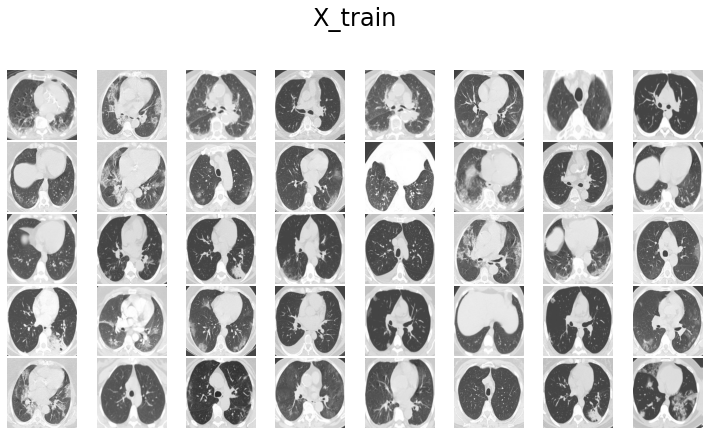

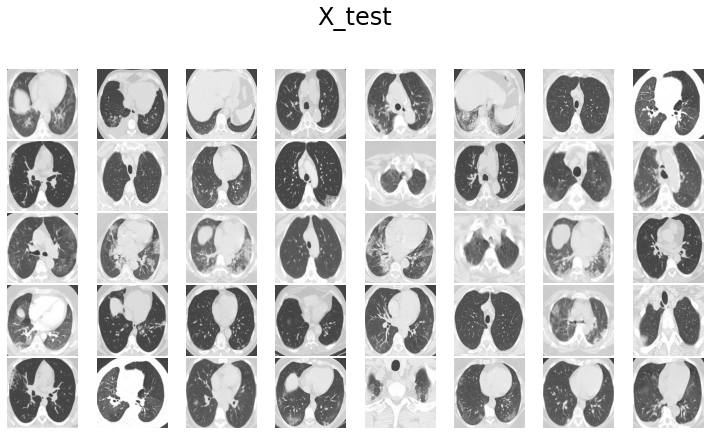

In [8]:
# look at random images (covid and non-covid)
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
    
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

Text(0.5, 1.0, 'Test Set')

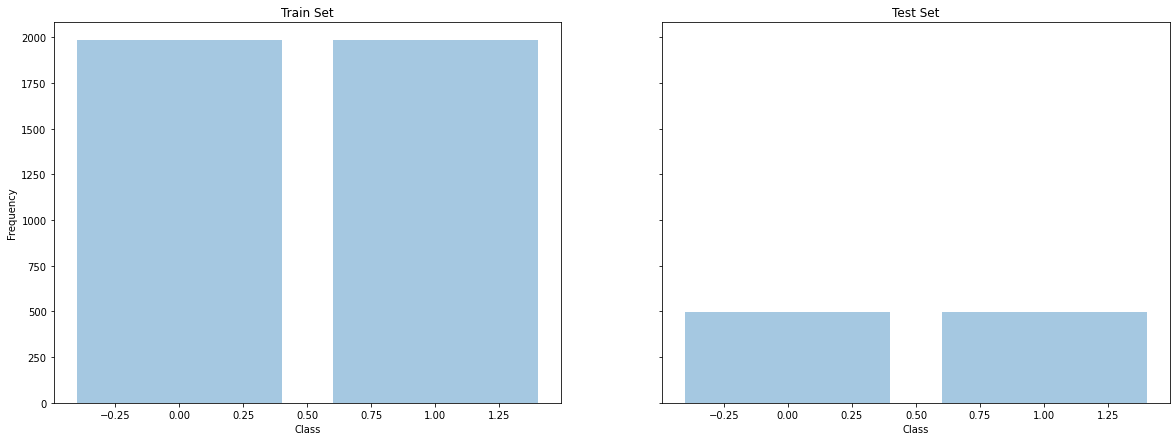

In [9]:
# Find the amount of classes and calculate the train and test data
unq_values_train, counts_train = np.unique(y_train, 
                                           return_counts=True 
                                          )
unq_values_test, counts_test = np.unique(y_test, return_counts=True)

# Graph for train data
fig, axis = plt.subplots(nrows=1, ncols=2,
                         sharey=True, 
                         figsize=(20,7))

axis[0].bar(unq_values_train, 
            counts_train, 
            align="center", 
            alpha=0.4 
           )
axis[0].set_xlabel("Class") 
axis[0].set_ylabel("Frequency") 
axis[0].set_title("Train Set") 

# Graph for test data
axis[1].bar(unq_values_test, counts_test, align="center", alpha=0.4)
axis[1].set_xlabel("Class")
axis[1].set_title("Test Set")

In [10]:
# Building Model
# Pre-trained DenseNet201
densenet201Model = DenseNet201(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = densenet201Model.output

# Add the extra layers
outputs = GlobalAveragePooling2D()(outputs)
outputs = Flatten(name="flatten")(outputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = Dense(64, activation='relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation="sigmoid")(outputs)

model = Model(inputs=densenet201Model.input, outputs=outputs)

for layer in densenet201Model.layers:
    layer.trainable = False

# Define loss function, optimizer and metric
model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [11]:
# Image Augmentation
# To train on images at different positions, angles, flips, e.t.c.
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [12]:
# Τraining config:
epochs = 500
batch_size = 32

# Train the model
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
62/62 [==============================] - 52s 554ms/step - loss: 0.6341 - accuracy: 0.6512 - val_loss: 0.4822 - val_accuracy: 0.7626
Epoch 2/500
62/62 [==============================] - 28s 454ms/step - loss: 0.4497 - accuracy: 0.7959 - val_loss: 0.3730 - val_accuracy: 0.8451
Epoch 3/500
62/62 [==============================] - 30s 472ms/step - loss: 0.3946 - accuracy: 0.8206 - val_loss: 0.3310 - val_accuracy: 0.8612
Epoch 4/500
62/62 [==============================] - 30s 476ms/step - loss: 0.3852 - accuracy: 0.8246 - val_loss: 0.3171 - val_accuracy: 0.8612
Epoch 5/500
62/62 [==============================] - 30s 485ms/step - loss: 0.3521 - accuracy: 0.8518 - val_loss: 0.3065 - val_accuracy: 0.8732
Epoch 6/500
62/62 [==============================] - 29s 471ms/step - loss: 0.3468 - accuracy: 0.8412 - val_loss: 0.4254 - val_accuracy: 0.7827
Epoch 7/500
62/62 [==============================] - 32s 507ms/step - loss: 0.3259 - accuracy: 0.8604 - val_loss: 0.3226 - val_accuracy:

62/62 [==============================] - 28s 455ms/step - loss: 0.1344 - accuracy: 0.9451 - val_loss: 0.1827 - val_accuracy: 0.9396
Epoch 114/500
62/62 [==============================] - 28s 454ms/step - loss: 0.1292 - accuracy: 0.9501 - val_loss: 0.2096 - val_accuracy: 0.9356
Epoch 115/500
62/62 [==============================] - 29s 471ms/step - loss: 0.1247 - accuracy: 0.9446 - val_loss: 0.1702 - val_accuracy: 0.9457
Epoch 116/500
62/62 [==============================] - 29s 460ms/step - loss: 0.1343 - accuracy: 0.9425 - val_loss: 0.1813 - val_accuracy: 0.9376
Epoch 117/500
62/62 [==============================] - 28s 453ms/step - loss: 0.1262 - accuracy: 0.9486 - val_loss: 0.1924 - val_accuracy: 0.9336
Epoch 118/500
62/62 [==============================] - 28s 441ms/step - loss: 0.1227 - accuracy: 0.9501 - val_loss: 0.1710 - val_accuracy: 0.9457
Epoch 119/500
62/62 [==============================] - 28s 444ms/step - loss: 0.1320 - accuracy: 0.9496 - val_loss: 0.1827 - val_accuracy:

62/62 [==============================] - 27s 437ms/step - loss: 0.0907 - accuracy: 0.9688 - val_loss: 0.1856 - val_accuracy: 0.9376
Epoch 226/500
62/62 [==============================] - 27s 439ms/step - loss: 0.1118 - accuracy: 0.9597 - val_loss: 0.1667 - val_accuracy: 0.9557
Epoch 227/500
62/62 [==============================] - 27s 438ms/step - loss: 0.0832 - accuracy: 0.9677 - val_loss: 0.1606 - val_accuracy: 0.9497
Epoch 228/500
62/62 [==============================] - 27s 440ms/step - loss: 0.1034 - accuracy: 0.9572 - val_loss: 0.2022 - val_accuracy: 0.9336
Epoch 229/500
62/62 [==============================] - 27s 437ms/step - loss: 0.0956 - accuracy: 0.9617 - val_loss: 0.1850 - val_accuracy: 0.9477
Epoch 230/500
62/62 [==============================] - 28s 443ms/step - loss: 0.0837 - accuracy: 0.9682 - val_loss: 0.1728 - val_accuracy: 0.9416
Epoch 231/500
62/62 [==============================] - 27s 438ms/step - loss: 0.0985 - accuracy: 0.9632 - val_loss: 0.1848 - val_accuracy:

62/62 [==============================] - 29s 466ms/step - loss: 0.0628 - accuracy: 0.9748 - val_loss: 0.1799 - val_accuracy: 0.9557
Epoch 338/500
62/62 [==============================] - 29s 465ms/step - loss: 0.0711 - accuracy: 0.9693 - val_loss: 0.1681 - val_accuracy: 0.9517
Epoch 339/500
62/62 [==============================] - 29s 462ms/step - loss: 0.0742 - accuracy: 0.9672 - val_loss: 0.2260 - val_accuracy: 0.9437
Epoch 340/500
62/62 [==============================] - 32s 513ms/step - loss: 0.0964 - accuracy: 0.9637 - val_loss: 0.2134 - val_accuracy: 0.9477
Epoch 341/500
62/62 [==============================] - 32s 511ms/step - loss: 0.0786 - accuracy: 0.9708 - val_loss: 0.2031 - val_accuracy: 0.9577
Epoch 342/500
62/62 [==============================] - 30s 480ms/step - loss: 0.0794 - accuracy: 0.9662 - val_loss: 0.2023 - val_accuracy: 0.9396
Epoch 343/500
62/62 [==============================] - 29s 464ms/step - loss: 0.0772 - accuracy: 0.9698 - val_loss: 0.1747 - val_accuracy:

62/62 [==============================] - 30s 484ms/step - loss: 0.0753 - accuracy: 0.9718 - val_loss: 0.1654 - val_accuracy: 0.9577
Epoch 450/500
62/62 [==============================] - 30s 477ms/step - loss: 0.0641 - accuracy: 0.9718 - val_loss: 0.1776 - val_accuracy: 0.9477
Epoch 451/500
62/62 [==============================] - 30s 480ms/step - loss: 0.0528 - accuracy: 0.9854 - val_loss: 0.1738 - val_accuracy: 0.9537
Epoch 452/500
62/62 [==============================] - 30s 482ms/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 0.1763 - val_accuracy: 0.9497
Epoch 453/500
62/62 [==============================] - 30s 483ms/step - loss: 0.0579 - accuracy: 0.9783 - val_loss: 0.1815 - val_accuracy: 0.9537
Epoch 454/500
62/62 [==============================] - 30s 478ms/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.1807 - val_accuracy: 0.9537
Epoch 455/500
62/62 [==============================] - 30s 483ms/step - loss: 0.0755 - accuracy: 0.9738 - val_loss: 0.1881 - val_accuracy:

In [13]:
# Save Model and Weights
model.save('densenet201_ct.h5')
model.save_weights('densenet201_weights_ct.hdf5')

In [14]:
# Load saved model
model = load_model('densenet201_ct.h5')

In [15]:
# Print the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 14, 14, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 14, 14, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 7, 7, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 7, 7, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 global_average_pooling2d (Glob  (None, 1920)        0           ['relu[0][0]']                   
 alAveragePooling2D)                                                                              
                                                                                                  
 flatten (Flatten)              (None, 1920)         0           ['global_average_pooling2d[0][0]'
                                                                 ]                                
          

In [16]:
batch_size = 32
y_pred = model.predict(X_test, batch_size=batch_size)

16/16 [==============================] - 8s 293ms/step


### Make some predictions


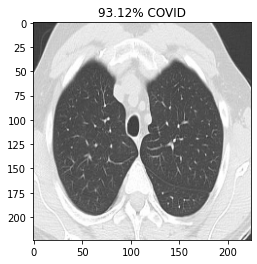

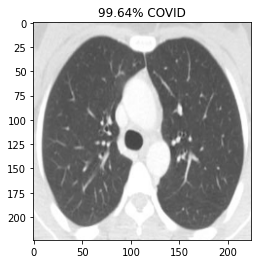

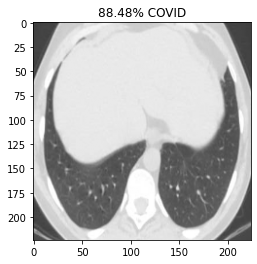

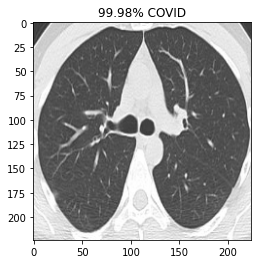

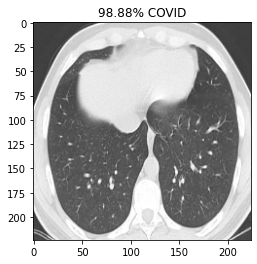

In [17]:
prediction=y_pred[0:5]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

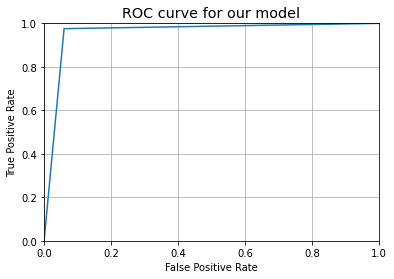

In [19]:
# Create ROC curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

The confusion matrix of the classification is: 
Predicted    0    1  All
Actual                  
0          236   15  251
1            6  240  246
All        242  255  497
----------------------------------------------------------------------------------------------------


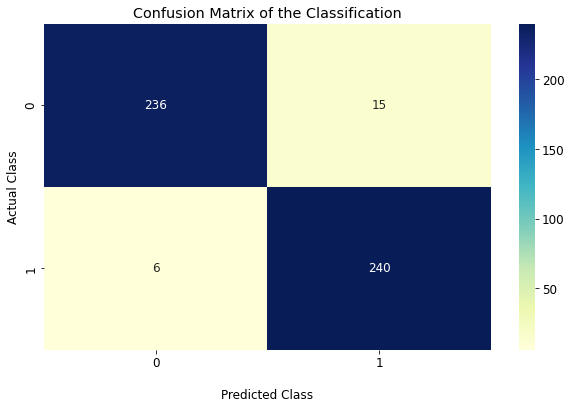

In [20]:
df = pd.DataFrame({"Y_Actual": y_test_bin, 
                  "Y_Predicted": y_pred_bin
                  }
                 )

# Create the Confusion Matrix
conf_mat = pd.crosstab(df["Y_Actual"],     # actual classes
                       df["Y_Predicted"],  # predicted
                       rownames=["Actual"],
                       colnames=["Predicted"],
                       margins=True
                      )  

print(f"The confusion matrix of the classification is: \n{conf_mat}")
print("-"*100)

conf_mat = conf_mat.drop("All", axis=0) 
conf_mat = conf_mat.drop("All", axis=1) 

# Create gragh
f, axis = plt.subplots(nrows=1, ncols=1, figsize=(10, 6)) 
sns.heatmap(conf_mat, 
            annot=True, 
            fmt="d", 
            cmap="YlGnBu", # initialize color map (YlGnBu - > Yello Green Blue)
            ax=axis
            )
axis.set_xlabel("\nPredicted Class")
axis.set_ylabel("Actual Class")
axis.set_title("Confusion Matrix of the Classification")

plt.show()

In [21]:
import sklearn.metrics
from sklearn.metrics import classification_report

# Calculate the accuracy
test_accuracy_nn = sklearn.metrics.accuracy_score(y_test_bin, y_pred_bin)

print("The Accuracy of the Neural Network on the Test Data is :", test_accuracy_nn)

The Accuracy of the Neural Network on the Test Data is : 0.9577464788732394


In [22]:
# Print the classification report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       251
           1       0.94      0.98      0.96       246

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



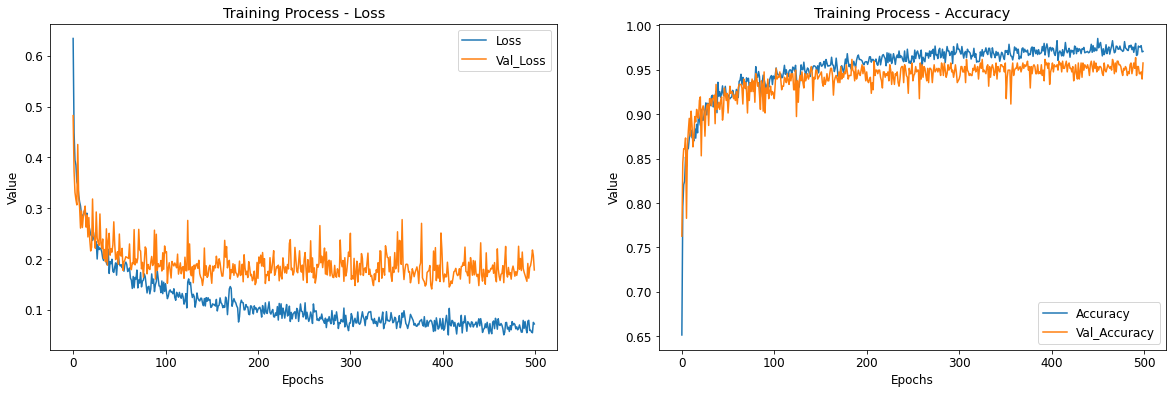

In [23]:
fig, axis = plt.subplots(nrows=1,ncols=2, figsize=(20,6))

# Create the first gragh (Loss -> Cross-Entropy)
axis[0].plot(history.epoch, history.history['loss']) # Cross Entropy - Training
axis[0].plot(history.epoch, history.history['val_loss']) # Cross Entropy - Validation
axis[0].set_xlabel("Epochs") 
axis[0].set_ylabel("Value") 
axis[0].legend(["Loss", "Val_Loss"]) 
axis[0].set_title("Training Process - Loss") 

# Create the second gragh (Accuracy)
axis[1].plot(history.epoch, history.history['accuracy'])
axis[1].plot(history.epoch, history.history['val_accuracy'])
axis[1].set_xlabel("Epochs") 
axis[1].set_ylabel("Value") 
axis[1].legend(["Accuracy", "Val_Accuracy"])
axis[1].set_title("Training Process - Accuracy")
plt.show()

In [3]:
# To run the next few cells create a folder with the 'X_train' images before the preprocess
import random

img_paths = glob(".\\kaggle\\val_set_kaggle\\*.png")
img_paths = [(img_paths[index]) for index in random.sample(range(0, len(img_paths)), len(img_paths))]

covid = 0
non_covid = 0

for file in img_paths:
    if "Non-Covid" in file:
        non_covid += 1
    else:
        covid += 1
print(non_covid)
print(covid)

983
1001


In [4]:
val_imgs = []

for img_path in img_paths:
    img = cv2.imread(img_path)                 # read file 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # arrange format as per kera
    img = cv2.resize(img,(224,224))            # resize as per model
    val_imgs.append(img)                       # append image

In [5]:
# Load the model that was trained above
model = keras.models.load_model("densenet201_ct.h5")

last_conv_layer = "conv5_block32_concat"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size) # `img` is a PIL image of size 224x224
    array = keras.preprocessing.image.img_to_array(img)                  # `array` is a float32 Numpy array of shape (224, 224, 3)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted)
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap_1 = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap_1)

    # For visualization purpose, also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### Grad-CAM

In [6]:
# Remove last layer's softmax
model.layers[-1].activation = None

In [7]:
# Display
from IPython.display import Image, display
import matplotlib.cm as cm

def create_gradcam(img_br, heatmap, cam_path="cam.jpg", alpha=0.3):
    heatmap = np.uint8(255 * heatmap)        # rescale heatmap to a range 0-255

    jet = cm.get_cmap("jet")                 # use jet colormap to colorize heatmap

    jet_colors = jet(np.arange(256))[:, :3]  # use RGB values of the colormap
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_br.shape[1], img_br.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img_rgb

### Content-Based Image Retrieval - CBIR

In [8]:
import os
import shutil

# Visualize five random images
plt.figure(figsize=(8, 8))

for i, img in enumerate(val_imgs):
    #ax = plt.subplot(1, 5, i+1)
    grad_cam = make_gradcam_heatmap(np.expand_dims(img, axis=0), model, last_conv_layer)
    grad_cam_emphasized = create_gradcam(img, grad_cam, cam_path="cam.jpg", alpha=0.3)
    
    #plt.axis('off')
    #plt.imshow(grad_cam_emphasized)
    
    file_destination_path = os.path.join('C:\\Users\\John\\Desktop\\deep\\kaggle\\grad_cam_images', os.path.splitext(os.path.basename(img_paths[i]))[0])
    grad_cam_emphasized.save(file_destination_path + ".png")
#plt.tight_layout()

<Figure size 576x576 with 0 Axes>

In [8]:
# Import the libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

import os
import numpy as np
from pathlib import Path
from PIL import Image

import cv2
import os

import tensorflow as tf
from tensorflow import keras

from random import shuffle

base_model = keras.models.load_model("densenet201_ct.h5")

class FeatureExtractor:
    def __init__(self):
        base_model = keras.models.load_model("densenet201_ct.h5")
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)
    
if __name__ == '__main__':
    fe = FeatureExtractor()

# This code snippet is used only when .npy files for each image are created.
#     for img_path in sorted(Path("C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle").glob("*.png")):
#         feature = fe.extract(img=Image.open(img_path))
#         feature_path = Path("C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle") / (img_path.stem + ".npy")
#         np.save(feature_path, feature)
#     for img_path in sorted(Path("C:\\Users\\John\\Desktop\\deep\\kaggle\\grad_cam_images").glob("*.png")):
#         feature_grad = fe.extract(img=Image.open(img_path))
#         feature_path = Path("C:\\Users\\John\\Desktop\\deep\\kaggle\\grad_cam_images") / (img_path.stem + ".npy")
#         np.save(feature_path, feature_grad)

### Evaluation Metrics

In [9]:
# Import the libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Variables
fe = FeatureExtractor()
features = []
features_cam = []
img_paths = []
image_paths = []

alpha = 1.5

first_tier_sum = 0
first_tier_sum_2 = 0
total_nn = 0
total_nn_2 = 0

# Extract the feautures of the images
for feature_path in Path(".\\kaggle\\val_set_kaggle").glob("*.npy"):
    features.append(np.load(feature_path))
    img_paths.append(Path(".\\kaggle\\val_set_kaggle") / (feature_path.stem + ".png"))
features = np.array(features) 
    
for feature_path_cam in Path(".\\kaggle\\grad_cam_images").glob("*.npy"):
    features_cam.append(np.load(feature_path_cam))
features_cam = np.array(features_cam) 

# For each image calculate the 'Nearest Neighbor' and 'First Tier' metrics
for image_path in img_paths:
    # Insert the image query
    img = Image.open(image_path)
    # Extract its features
    query = fe.extract(img)

    # Calculate the similarity (distance) between images
    dists = np.linalg.norm(features - query, axis=1)
    # Extract 5 images that have lowest distance
    ids = np.argsort(dists)[:5]
    scores = [(dists[id], img_paths[id]) for id in ids]

    features_mod = features * features_cam
    query_mod = query * features_cam

    # Calculate the similarity (distance) between images
    dists_2 = np.linalg.norm(features_mod - query_mod, axis = 1)
    # Extract 5 images that have lowest distance
    ids_2 = np.argsort(dists_2)[:5]
    scores_2 = [(dists_2[id], img_paths[id]) for id in ids_2]

    dists_final = dists + alpha * dists_2
    # Extract 5 images that have lowest distance
    ids_final = np.argsort(dists_final)[:5]
    scores_final = [(dists_final[id], img_paths[id]) for id in ids_final]

    images = [(img_paths[id]) for id in ids]
    images = [str(image) for image in images]

    images_final = [(img_paths[id]) for id in ids_final]
    images_final = [str(image) for image in images_final]

    non_covid = [img for img in images if os.path.basename(img).startswith("Non-Covid")]
    covid = [img for img in images if img not in non_covid]

    non_covid_final = [img for img in images_final if os.path.basename(img).startswith("Non-Covid")]
    covid_final = [img for img in images_final if img not in non_covid_final]

    relevant_images = non_covid if os.path.basename(image_path).startswith("Non-Covid") else covid
    relevant_images_final = non_covid_final if os.path.basename(image_path).startswith("Non-Covid") else covid_final
    
    basename_prefix = os.path.basename(image_path).split(" ")[0]
    
    # Nearest Neighbor- Simple CBIR
    nn = 0
    if os.path.basename(images[1]).startswith(basename_prefix):
        nn += 1
    total_nn += nn
    
    # Nearest Neighbor-CBIR/Grad-CAM
    nn_2 = 0
    if os.path.basename(images_final[1]).startswith(basename_prefix):
        nn_2 += 1
    total_nn_2 += nn_2
    
    # First tier - Simple CBIR
    first_tier = len(relevant_images) / 5
    first_tier_sum += first_tier
    
    # First tier - CBIR/Grad-CAM
    first_tier_2 = len(relevant_images_final) / 5
    first_tier_sum_2 += first_tier_2

# Print the final results
print('Nearest Neighbor sum:', round(total_nn / len(glob.glob('C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle\\*.png')),4))
print('Nearest Neighbor cbir/grad sum:', round(total_nn_2 / len(glob.glob('C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle\\*.png')),4))
print('First four sum cbir:', round(first_tier_sum / len(glob.glob('C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle\\*.png')), 4))
print('First four sum cbir/grad:', round(first_tier_sum_2 / len(glob.glob('C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle\\*.png')), 4))

1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 51ms/step
Nearest Neighbor sum: 0.9713
Nearest Neighbor cbir/grad sum: 0.9698
First four sum cbir: 0.9409
First four sum cbir/grad: 0.939


### Creation of Figure 3

In [15]:
IMG_SIZE = 224

def process_data(image_list, IMG_SIZE):
    data_df = []
    for img in image_list:
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data_df.append([np.array(img)])
    shuffle(data_df)
    return data_df

def manual_pre_process(dir, IMG_SIZE):
    data_df = process_data(dir, IMG_SIZE)
    X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return X

In [16]:
imgs = manual_pre_process(images, 224)

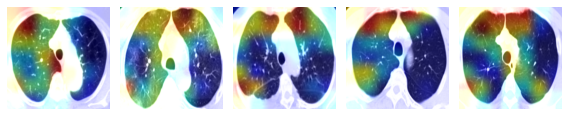

In [17]:
import os
import shutil

# Visualize five random images
plt.figure(figsize=(8, 8))

for i, img in enumerate(imgs):
    ax = plt.subplot(1, 5, i+1)
    grad_cam = make_gradcam_heatmap(np.expand_dims(img, axis=0), model, last_conv_layer)
    grad_cam_emphasized = create_gradcam(img, grad_cam, cam_path="cam.jpg", alpha=0.4)
    plt.axis('off')
    plt.imshow(grad_cam_emphasized)
plt.tight_layout()

1/1 [==============================] - 3s 3s/step


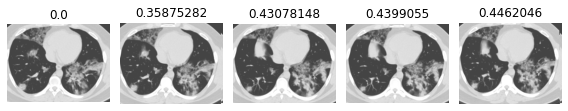

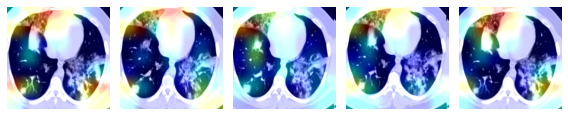

In [24]:
# Simple CBIR

# Calculate the distances of the five more similar images
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Read image features
fe = FeatureExtractor()
features = []
img_paths = []

for feature_path in Path("C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle").glob("*.npy"):
    features.append(np.load(feature_path))
    img_paths.append(Path('C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle') / (feature_path.stem + ".png"))
    
# Insert the image query
img = Image.open("C:\\Users\\John\\Desktop\\deep\\kaggle\\val_set_kaggle\\Covid (30).png")
# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis = 1)
# Extract 5 images that have lowest distance
ids = np.argsort(dists)[:5]
scores = [(dists[id], img_paths[id]) for id in ids]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for index,score in enumerate(scores):
    axes.append(fig.add_subplot(1, 5, index+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

images = [(img_paths[id]) for id in ids]
images = [str(image) for image in images]

imgs = manual_pre_process(images, 224)

# Visualize five random images
plt.figure(figsize=(8, 8))

for i, img in enumerate(imgs):
    ax = plt.subplot(1, 5, i+1)
    grad_cam = make_gradcam_heatmap(np.expand_dims(img, axis=0), model, last_conv_layer)
    grad_cam_emphasized = create_gradcam(img, grad_cam, cam_path="cam.jpg", alpha=0.4)
    plt.axis('off')
    plt.imshow(grad_cam_emphasized)
plt.tight_layout()

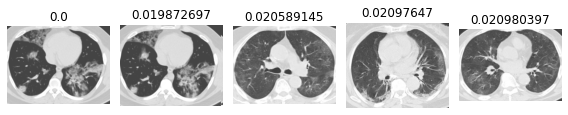

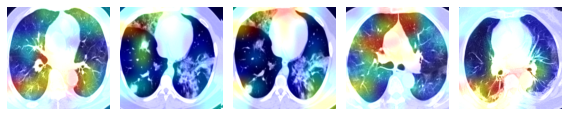

In [25]:
# Grad-CAM
features_cam = []

features_cam = np.load('C:\\Users\\John\\Desktop\\deep\\kaggle\\grad_cam_images\\Non-Covid (1198).npy')

features_mod = features_cam * features
query_mod = query * features_cam

# Calculate the similarity (distance) between images
dists_2 = np.linalg.norm(features_mod - query_mod, axis = 1)
# Extract 5 images that have lowest distance
ids_2 = np.argsort(dists_2)[:5]
scores_2 = [(dists_2[id], img_paths[id]) for id in ids_2]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for index,score in enumerate(scores_2):
    axes.append(fig.add_subplot(1, 5, index+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

images_2 = [(img_paths[id]) for id in ids_2]
images_2 = [str(image) for image in images_2]

imgs_2 = manual_pre_process(images_2, 224)

# Visualize five random images
plt.figure(figsize=(8, 8))

for i, img in enumerate(imgs_2):
    ax = plt.subplot(1, 5, i+1)
    grad_cam = make_gradcam_heatmap(np.expand_dims(img, axis=0), model, last_conv_layer)
    grad_cam_emphasized = create_gradcam(img, grad_cam, cam_path="cam.jpg", alpha=0.4)
    plt.axis('off')
    plt.imshow(grad_cam_emphasized)
plt.tight_layout()

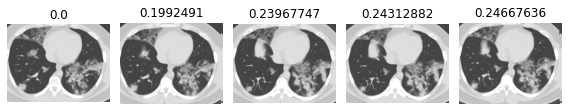

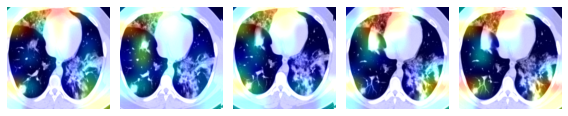

In [26]:
# CBIR / Grad-CAM
alpha = 0.5 

dists_final = alpha * dists + dists_2
# Extract 5 images that have lowest distance
ids_final = np.argsort(dists_final)[:5]
scores_final = [(dists_final[id], img_paths[id]) for id in ids_final]

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))
for index,score in enumerate(scores_final):
    axes.append(fig.add_subplot(1, 5, index+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
fig.tight_layout()
plt.show()

images_final = [(img_paths[id]) for id in ids_final]
images_final = [str(image) for image in images_final]

imgs_final = manual_pre_process(images_final, 224)

# Visualize five random images
plt.figure(figsize=(8, 8))

for i, img in enumerate(imgs_final):
    ax = plt.subplot(1, 5, i+1)
    grad_cam = make_gradcam_heatmap(np.expand_dims(img, axis=0), model, last_conv_layer)
    grad_cam_emphasized = create_gradcam(img, grad_cam, cam_path="cam.jpg", alpha=0.4)
    plt.axis('off')
    plt.imshow(grad_cam_emphasized)
plt.tight_layout()